## Setting up the Environment

In [2]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [52]:
#list of csv files and their corresponding tables
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv' , 'order_items') # Added payments.csv for specific handling
]


In [54]:
# Folder containing the CSV files
folder_path = r"C:\Users\r7783\Desktop\Ecommerce"


In [56]:
import mysql.connector
import os
import pandas as pd

def get_sql_type(pandas_dtype):
    # This function should map Pandas dtypes to SQL data types.
    if pd.api.types.is_integer_dtype(pandas_dtype):
        return "INT"
    elif pd.api.types.is_float_dtype(pandas_dtype):
        return "FLOAT"
    elif pd.api.types.is_object_dtype(pandas_dtype):
        return "TEXT"
    elif pd.api.types.is_bool_dtype(pandas_dtype):
        return "BOOLEAN"
    else:
        return "TEXT"  # Default type

try:
    # Step 1: Establish a new connection to MySQL
    conn = mysql.connector.connect(
        host="localhost",
        username="root",
        password="38221468",  # Replace with your password
        database="e-commerce"
    )
    
    cursor = conn.cursor()  # Step 2: Create a cursor object
    
    # Assuming csv_files is a list of tuples like [(csv_file1, table_name1), ...]
    for csv_file, table_name in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        
        # Replace NaN with None to handle SQL NULL
        df = df.where(pd.notnull(df), None)
        
        # Debugging: Check for NaN values
        print(f"Processing {csv_file}")
        print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

        # Clean column names
        df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

        # Generate the CREATE TABLE statement with appropriate data types
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        
        # Step 3: Execute the CREATE TABLE query
        cursor.execute(create_table_query)

        # Insert DataFrame data into the MySQL table
        for _, row in df.iterrows():
            # Convert row to tuple and handle NaN/None explicitly
            values = tuple(None if pd.isna(x) else x for x in row)
            sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
            cursor.execute(sql, values)

        # Step 4: Commit the transaction for the current CSV file
        conn.commit()

except mysql.connector.ProgrammingError as e:
    print(f"Programming Error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Step 5: Close the cursor and connection to free resources
    if cursor:
        cursor.close()
    if conn:
        conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import os

db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "38221468",
                            database = "e-commerce")

cur = db.cursor()

## 1.List all unique cities where customers are located.

In [9]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()



,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


## Count the number of orders placed in 2017.


In [12]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 270606)

## Find the total sales per category.

In [15]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,ART,495886.88
1,COOL STUFF,12475168.00
2,GAMES CONSOLES,3127686.07
3,TELEPHONY,7790112.81
4,SPORT LEISURE,22274040.95
...,...,...
69,CDS MUSIC DVDS,19190.88
70,LA CUISINE,46616.48
71,FASHION CHILDREN'S CLOTHING,12570.72
72,PC GAMER,34790.88


## Calculate the percentage of orders that were paid in installments.

In [18]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]


('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

## Count the number of customers from each state.

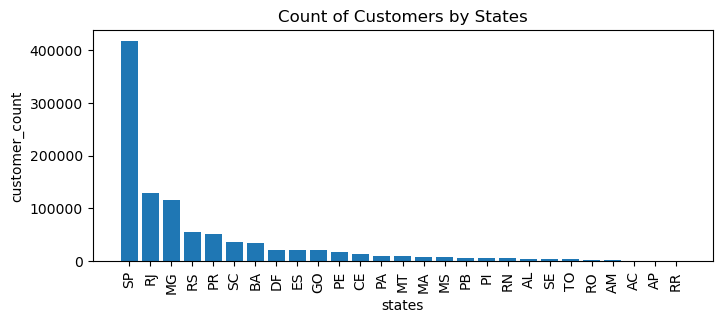

In [21]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()


## Calculate the number of orders per month in 2018.

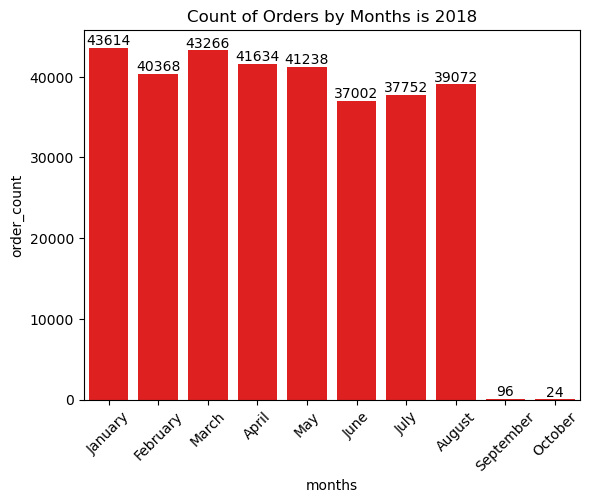

In [24]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()


## Find the average number of products per order, grouped by customer city.

In [27]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,42.00
1,celso ramos,39.00
2,datas,36.00
3,candido godoi,36.00
4,matias olimpio,30.00
5,cidelandia,24.00
6,curralinho,24.00
7,picarra,24.00
8,morro de sao paulo,24.00
9,teixeira soares,24.00


## Calculate the percentage of total revenue contributed by each product category.


In [30]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71


## Identify the correlation between product price and the number of times a product has been purchased.

In [34]:
import numpy as np

In [36]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157564


## Calculate the total revenue generated by each seller, and rank them by revenue.

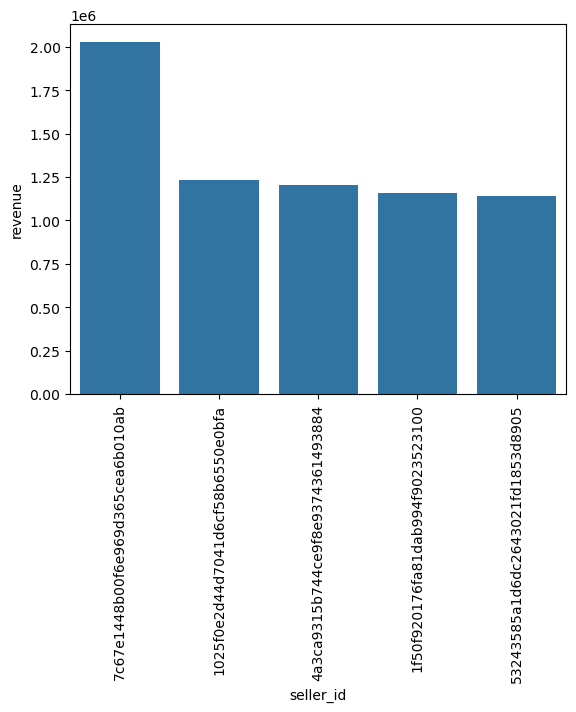

In [39]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

## Calculate the moving average of order values for each customer over their order history.

In [42]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
2493259,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2493260,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2493261,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2493262,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


## Calculate the cumulative sales per month for each year.

In [45]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,6053.76,6.053760e+03
1,2016,10,1418171.52,1.424225e+06
2,2016,12,470.88,1.424696e+06
3,2017,1,3323712.96,4.748409e+06
4,2017,2,7005792.23,1.175420e+07
5,2017,3,10796726.39,2.255093e+07
6,2017,4,10026912.71,3.257784e+07
7,2017,5,14230051.68,4.680789e+07
8,2017,6,12270633.13,5.907853e+07
9,2017,7,14217190.07,7.329572e+07


## Calculate the year-over-year growth rate of total sales.

In [48]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df


,years,yoy % growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


## Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [51]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data


[(None,)]

## Identify the top 3 customers who spent the most money in each year.


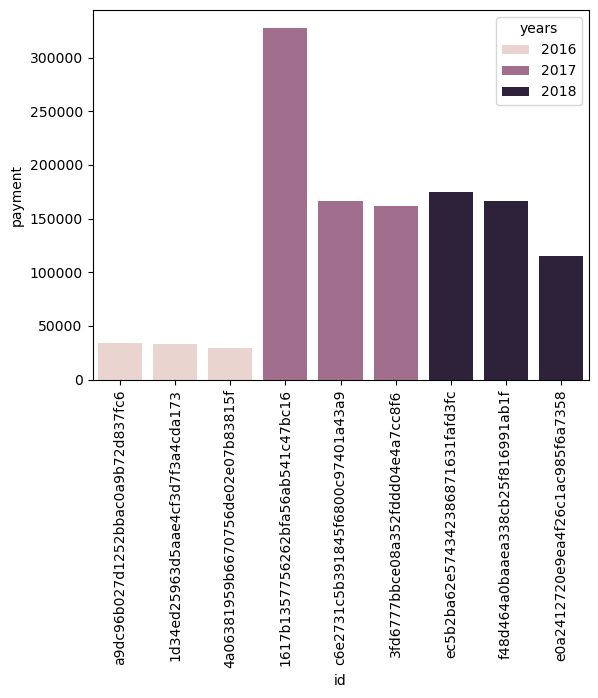

In [53]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()